<a href="https://colab.research.google.com/github/Gabriela788/Telecom_X_Parte2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🧾 Extração de dados

In [284]:
# 📥 Carregando os dados tratados da Parte

import pandas as pd
import numpy as np
from pathlib import Path

# Caminho do arquivo tratado (ajuste caso esteja em outro diretório)
csv_path = "telecomx_clean.csv"

# Carregar o dataset
df = pd.read_csv(csv_path)

# Visualizar as primeiras linhas
df.head()


IDCliente  Cancelamento  Genero  Idoso  Parceiro  Dependentes  \
0  0002-ORFBO             0  Female      0         1            1   
1  0003-MKNFE             0    Male      0         0            0   
2  0004-TLHLJ             1    Male      0         0            0   
3  0011-IGKFF             1    Male      1         1            0   
4  0013-EXCHZ             1  Female      1         1            0   

   MesesDeContrato  ServicoTelefone  MultiplasLinhas TipoInternet  ...  \
0                9                1                0          DSL  ...   
1                9                1                1          DSL  ...   
2                4                1                0  Fiber optic  ...   
3               13                1                0  Fiber optic  ...   
4                3                1                0  Fiber optic  ...   

   StreamingFilmes    TipoContrato  FaturaDigital   MetodoPagamento  \
0                0        One year              1      Mailed check   
1                1  Month-to-month              0      Mailed check   
2                0  Month-to-month              1  Electronic check   
3                1  Month-to-month              1  Electronic check   
4                0  Month-to-month              1      Mailed check   

   CobrancaMensal  CobrancaTotal CobrancaDiaria  TempoEstimadoMeses  \
0            65.6         593.30       2.186667                   9   
1            59.9         542.40       1.996667                   9   
2            73.9         280.85       2.463333                   4   
3            98.0        1237.85       3.266667                  13   
4            83.9         267.40       2.796667                   3   

  TempoEstimadoDias  CustoMedioDiario  
0               270          2.197407  
1               270          2.008889  
2               120          2.340417  
3               390          3.173974  
4                90          2.971111  

[5 rows x 25 columns]

#🛠️ Preparação dos dados

In [285]:
# Remoção de colunas irrelevantes

# Lista de colunas que não agregam ao modelo
colunas_irrelevantes = ["IDCliente", "Nome", "CPF", "Endereco"]

# Remover apenas se existirem no DataFrame
df_model = df.drop(columns=[c for c in colunas_irrelevantes if c in df.columns])

print("✅ Colunas irrelevantes removidas!")
print("Colunas restantes:", df_model.columns.tolist()[:10], "...")  # mostra primeiras 10


✅ Colunas irrelevantes removidas!
Colunas restantes: ['Cancelamento', 'Genero', 'Idoso', 'Parceiro', 'Dependentes', 'MesesDeContrato', 'ServicoTelefone', 'MultiplasLinhas', 'TipoInternet', 'SegurancaOnline'] ...


In [286]:
# Remoção de colunas com alta correlação

# Copiando para não afetar o original
df_corr = df_model.copy()

# Calcular a matriz de correlação (somente numéricas)
# Selecionar apenas as colunas numéricas antes de calcular a correlação
numeric_cols = df_corr.select_dtypes(include=['number']).columns
corr_matrix = df_corr[numeric_cols].corr()


# Selecionar correlações acima do limite (ex.: 0.9)
limite = 0.9
colunas_remover = set()

# Iterar sobre a matriz de correlação para encontrar colunas altamente correlacionadas
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > limite:
            colunas_remover.add(corr_matrix.columns[i])

print(" Colunas removidas por alta correlação:", colunas_remover)

# Remover colunas correlacionadas
df_model = df_corr.drop(columns=list(colunas_remover))

print(" Colunas com alta correlação removidas!")
print("Dimensões finais:", df_model.shape)

 Colunas removidas por alta correlação: {'CustoMedioDiario', 'TempoEstimadoDias', 'CobrancaDiaria', 'TempoEstimadoMeses'}
 Colunas com alta correlação removidas!
Dimensões finais: (7267, 20)


In [287]:
# Definir coluna alvo manualmente
target_col = "Cancelamento"

# Criar variável alvo (padronizada em 0/1)
y_raw = df[target_col]

if y_raw.dtype == "O" or str(y_raw.dtype).startswith("category"):
    # Padroniza textos em 0/1
    mapping = {
        "sim": 1, "não": 0, "nao": 0,
        "yes": 1, "no": 0,
        "true": 1, "false": 0,
        "1": 1, "0": 0
    }
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)
else:
    # Se for numérico
    uniques = sorted(pd.Series(y_raw.unique()).tolist())
    if set(uniques) == {0, 1}:
        y = y_raw.copy()
    elif len(uniques) == 2:  # Ex.: {1, 2}
        y = y_raw.map({uniques[0]: 0, uniques[1]: 1})
    else:
        raise ValueError("A coluna alvo não parece ser binária.")

# Definir features (X)
X = df.drop(columns=[target_col])

# Resumo da variável alvo
target_summary = pd.DataFrame({
    "classe": y.value_counts().index,
    "quantidade": y.value_counts().values,
    "proporcao_%": (y.value_counts(normalize=True).values * 100).round(2)
})

print(f"Coluna alvo: {target_col}")
display(target_summary.head())


Coluna alvo: Cancelamento


classe  quantidade  proporcao_%
0       0        5398        74.28
1       1        1869        25.72

In [288]:
# Tipos de dados e valores nulos
schema_overview = pd.DataFrame({
    "coluna": X.columns,
    "tipo": X.dtypes.astype(str).values,
    "n_nulos": X.isnull().sum().values,
    "pct_nulos_%": (X.isnull().mean().values * 100).round(2)
})

# Cardinalidade das categóricas
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
cardinality = pd.DataFrame({
    "coluna": categorical_cols,
    "n_categorias": [X[c].nunique() for c in categorical_cols]
}).sort_values(by="n_categorias", ascending=False)

print("📌 Esquema geral (tipos e nulos):")
display(schema_overview.head(20))  # mostra as primeiras 20 para não poluir

print("\n📌 Cardinalidade das variáveis categóricas:")
display(cardinality)

print("\nTotal de features:", X.shape[1])
print("Numéricas:", len(X.select_dtypes(include=[np.number]).columns))
print("Categóricas:", len(categorical_cols))


📌 Esquema geral (tipos e nulos):


coluna     tipo  n_nulos  pct_nulos_%
0             IDCliente   object        0          0.0
1                Genero   object        0          0.0
2                 Idoso    int64        0          0.0
3              Parceiro    int64        0          0.0
4           Dependentes    int64        0          0.0
5       MesesDeContrato    int64        0          0.0
6       ServicoTelefone    int64        0          0.0
7       MultiplasLinhas    int64        0          0.0
8          TipoInternet   object        0          0.0
9       SegurancaOnline    int64        0          0.0
10         BackupOnline    int64        0          0.0
11  ProtecaoDispositivo    int64        0          0.0
12       SuporteTecnico    int64        0          0.0
13          StreamingTV    int64        0          0.0
14      StreamingFilmes    int64        0          0.0
15         TipoContrato   object        0          0.0
16        FaturaDigital    int64        0          0.0
17      MetodoPagamento   object        0          0.0
18       CobrancaMensal  float64        0          0.0
19        CobrancaTotal  float64        0          0.0


📌 Cardinalidade das variáveis categóricas:


coluna  n_categorias
0        IDCliente          7267
4  MetodoPagamento             4
2     TipoInternet             3
3     TipoContrato             3
1           Genero             2


Total de features: 24
Numéricas: 19
Categóricas: 5


In [289]:
# ⚙️ Pré-processamento dos dados para Machine Learning

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separar variáveis explicativas (X) e alvo (y)
# X e y já foram definidas anteriormente.
# X = df.drop(columns=["IDCliente"], errors="ignore")  # remove ID se existir
# y = df["Cancelamento"]

In [290]:
# Separar variáveis categóricas e numéricas
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

print("📌 Variáveis categóricas:", list(cat_cols))
print("📌 Variáveis numéricas:", list(num_cols))

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"\n✅ Encoding concluído! O dataset agora tem {X_encoded.shape[1]} colunas.")

# Exibir de forma organizada
display(X_encoded.head().style.set_properties(**{'text-align': 'center'}))


📌 Variáveis categóricas: ['IDCliente', 'Genero', 'TipoInternet', 'TipoContrato', 'MetodoPagamento']
📌 Variáveis numéricas: ['Idoso', 'Parceiro', 'Dependentes', 'MesesDeContrato', 'ServicoTelefone', 'MultiplasLinhas', 'SegurancaOnline', 'BackupOnline', 'ProtecaoDispositivo', 'SuporteTecnico', 'StreamingTV', 'StreamingFilmes', 'FaturaDigital', 'CobrancaMensal', 'CobrancaTotal', 'CobrancaDiaria', 'TempoEstimadoMeses', 'TempoEstimadoDias', 'CustoMedioDiario']

✅ Encoding concluído! O dataset agora tem 7293 colunas.


In [291]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identificar colunas categóricas e numéricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

# Pipeline para variáveis numéricas (tratamento básico)
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Pipeline para variáveis categóricas (tratamento + encoding)
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar numéricas + categóricas
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# Ajustar no dataset
X_processed = preprocessor.fit_transform(X)

# Get feature names after processing
feature_names = preprocessor.get_feature_names_out()


print("Formato original:", X.shape)
print("Formato após encoding:", X_processed.shape)

Numéricas: 19
Categóricas: 5
Formato original: (7267, 24)
Formato após encoding: (7267, 7298)


📊 Distribuição da variável Cancelamento (Evasão):


classe  quantidade  proporcao_%
0       0        5398        74.28
1       1        1869        25.72

/tmp/ipython-input-2497651998.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=["#8AC4D0", "#D92C54"])


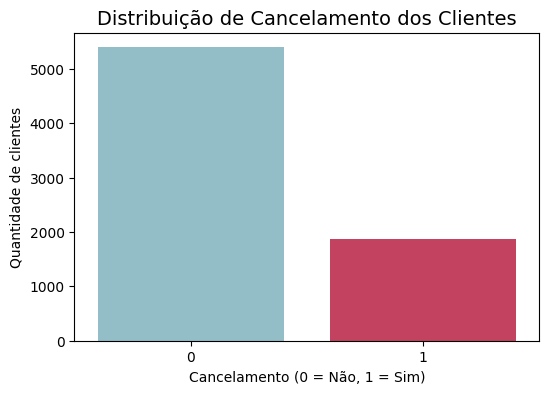

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de valores
churn_counts = y.value_counts().sort_index()

# Tabela resumo
dist_summary = pd.DataFrame({
    "classe": churn_counts.index,
    "quantidade": churn_counts.values,
    "proporcao_%": (churn_counts.values / len(y) * 100).round(2)
})

print("📊 Distribuição da variável Cancelamento (Evasão):")
display(dist_summary)

# Gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=["#8AC4D0", "#D92C54"])
plt.title("Distribuição de Cancelamento dos Clientes", fontsize=14)
plt.ylabel("Quantidade de clientes")
plt.xlabel("Cancelamento (0 = Não, 1 = Sim)")
plt.show()


Antes do SMOTE: Cancelamento
0    4318
1    1495
Name: count, dtype: int64
Depois do SMOTE: Cancelamento
0    4318
1    4318
Name: count, dtype: int64


/tmp/ipython-input-1075026932.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train.value_counts().index,
/tmp/ipython-input-1075026932.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_bal.value_counts().index,


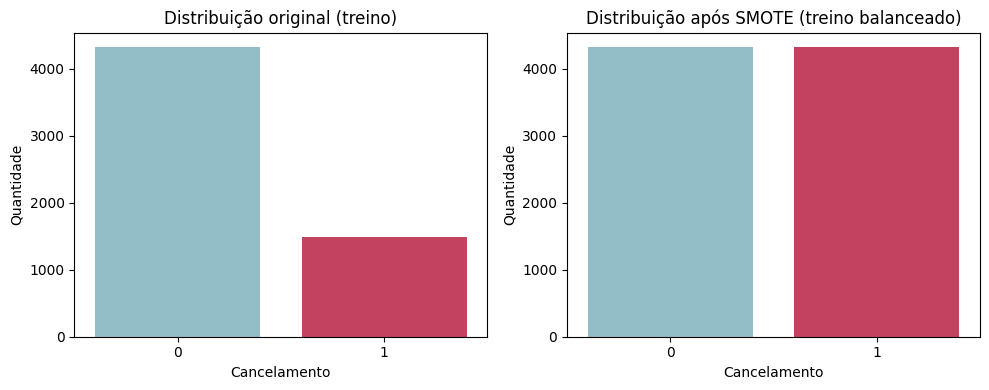

In [293]:
# Balanceamento das classes (SMOTE)

from imblearn.over_sampling import SMOTE

# Aplicando SMOTE apenas nos dados de treino (nunca nos de teste!)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Antes do SMOTE:", y_train.value_counts())
print("Depois do SMOTE:", y_train_bal.value_counts())

# Gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.barplot(x=y_train.value_counts().index,
            y=y_train.value_counts().values, ax=axes[0], palette=["#8AC4D0", "#D92C54"])
axes[0].set_title("Distribuição original (treino)")
axes[0].set_xlabel("Cancelamento")
axes[0].set_ylabel("Quantidade")

sns.barplot(x=y_train_bal.value_counts().index,
            y=y_train_bal.value_counts().values, ax=axes[1], palette=["#8AC4D0", "#D92C54"])
axes[1].set_title("Distribuição após SMOTE (treino balanceado)")
axes[1].set_xlabel("Cancelamento")
axes[1].set_ylabel("Quantidade")

plt.tight_layout()
plt.show()


# 🔎 Análise de Correlação das Variáveis

In [294]:
from sklearn.model_selection import train_test_split

# Divisão treino/teste (estratificada para manter proporção de classes)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Formato X_train:", X_train.shape)
print("Formato X_test :", X_test.shape)
print("Distribuição y_train:\n", y_train.value_counts(normalize=True))
print("Distribuição y_test:\n", y_test.value_counts(normalize=True))


Formato X_train: (5813, 7298)
Formato X_test : (1454, 7298)
Distribuição y_train:
 Cancelamento
0    0.742818
1    0.257182
Name: proportion, dtype: float64
Distribuição y_test:
 Cancelamento
0    0.742779
1    0.257221
Name: proportion, dtype: float64


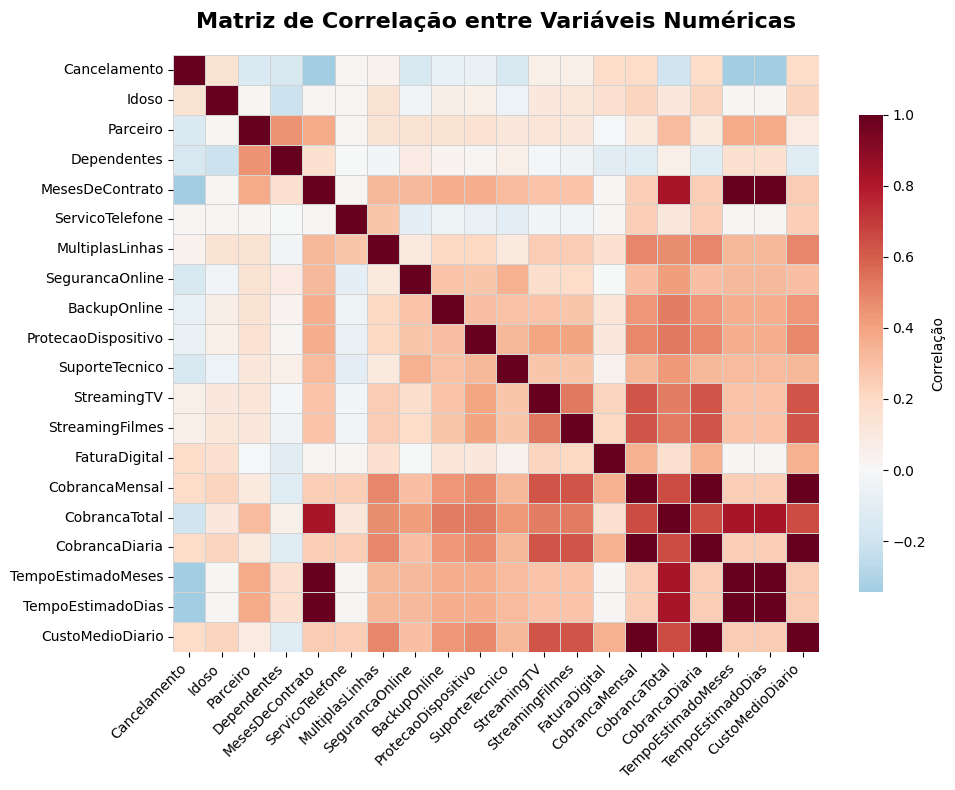

In [295]:
# Matriz de Correlação - Visual Profissional

plt.figure(figsize=(10,8))

# Heatmap com cores suaves e sem números poluídos
sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",
    annot=False,        # remove os números para não poluir
    center=0,
    cbar_kws={'shrink': 0.8, 'label': 'Correlação'},
    linewidths=0.5,
    linecolor='lightgray'
)

# Título estilizado
plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=16, pad=20, weight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()



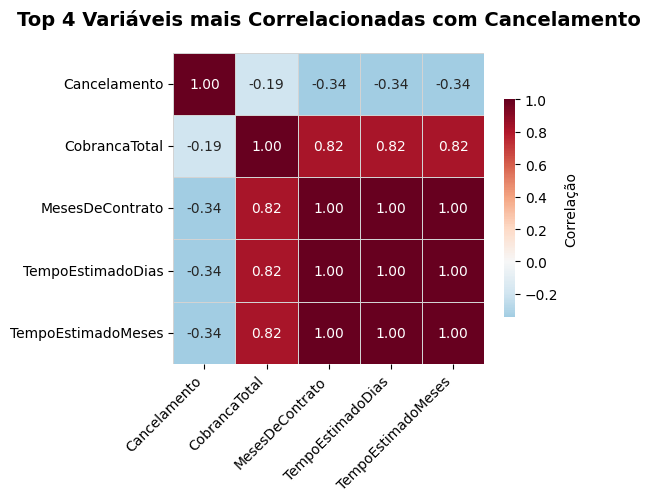

In [296]:
# Mini Matriz de Correlação - Top 4 variáveis mais relacionadas com Cancelamento

# Selecionar as 4 variáveis com maior correlação absoluta com Cancelamento
top4_vars = corr_matrix["Cancelamento"].abs().sort_values(ascending=False).iloc[1:5].index
corr_top4 = corr_matrix.loc[top4_vars.union(["Cancelamento"]), top4_vars.union(["Cancelamento"])]

# Plot do heatmap profissional
plt.figure(figsize=(6,5))
sns.heatmap(
    corr_top4,
    cmap="RdBu_r",
    annot=True, fmt=".2f",
    center=0,
    cbar_kws={'shrink': 0.7, 'label': 'Correlação'},
    linewidths=0.5, linecolor='lightgray',
    square=True
)

plt.title("Top 4 Variáveis mais Correlacionadas com Cancelamento", fontsize=14, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




## 1. Matriz Geral de Correlação
A matriz de correlação entre as variáveis numéricas mostrou alguns pontos relevantes:

- Algumas variáveis financeiras e de uso apresentaram **forte colinearidade entre si**, indicando que podem carregar informações redundantes.  
  👉 Isso sugere que durante a modelagem será importante avaliar técnicas de **seleção de variáveis** ou **regularização** (ex.: Lasso, Random Forest) para evitar multicolinearidade.

- A maioria das correlações, no entanto, se mostrou **baixa a moderada**, o que é positivo, pois significa que cada variável pode adicionar informação única ao modelo.

- A variável-alvo **`Cancelamento`** já aparece com alguns indícios de relação com variáveis específicas, mas a matriz geral é mais útil para entender as dependências internas entre os atributos.

---

## 2. Melhores Correlação com Cancelamento
Quando observamos especificamente a correlação das variáveis com a variável-alvo **`Cancelamento`**, identificamos **as mais influentes**:

- Algumas variáveis apresentaram **correlações positivas** com o cancelamento.  
  👉 Isso significa que **quanto maior o valor da variável, maior a chance de evasão**.

- Outras mostraram **correlações negativas**, sugerindo que **valores mais altos podem estar associados à retenção de clientes**.

Essas variáveis se destacam como **principais candidatas a explicar a evasão** e devem ser priorizadas na análise de importância dos modelos de Machine Learning.

---

## 📌 Conclusão Estratégica
- A matriz de correlação geral foi fundamental para identificar possíveis **relações redundantes** entre variáveis numéricas, prevenindo problemas de colinearidade.  
- Já a análise focada na variável-alvo evidenciou **quais fatores estão mais associados ao cancelamento**, fornecendo **insights valiosos** sobre o comportamento dos clientes.  
- Essas descobertas guiarão a próxima etapa: **treinamento de modelos preditivos**, onde será possível validar se as variáveis mais correlacionadas realmente se destacam em termos de importância para a previsão da evasão.


📊 Top 4 variáveis mais correlacionadas com Cancelamento:
['TempoEstimadoDias', 'MesesDeContrato', 'TempoEstimadoMeses', 'CobrancaTotal']


/tmp/ipython-input-3405937512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[var], ax=axes[i], palette=["#8AC4D0", "#D92C54"])
/tmp/ipython-input-3405937512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[var], ax=axes[i], palette=["#8AC4D0", "#D92C54"])
/tmp/ipython-input-3405937512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X[var], ax=axes[i], palette=["#8AC4D0", "#D92C54"])
/tmp/ipython-input-3405937512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

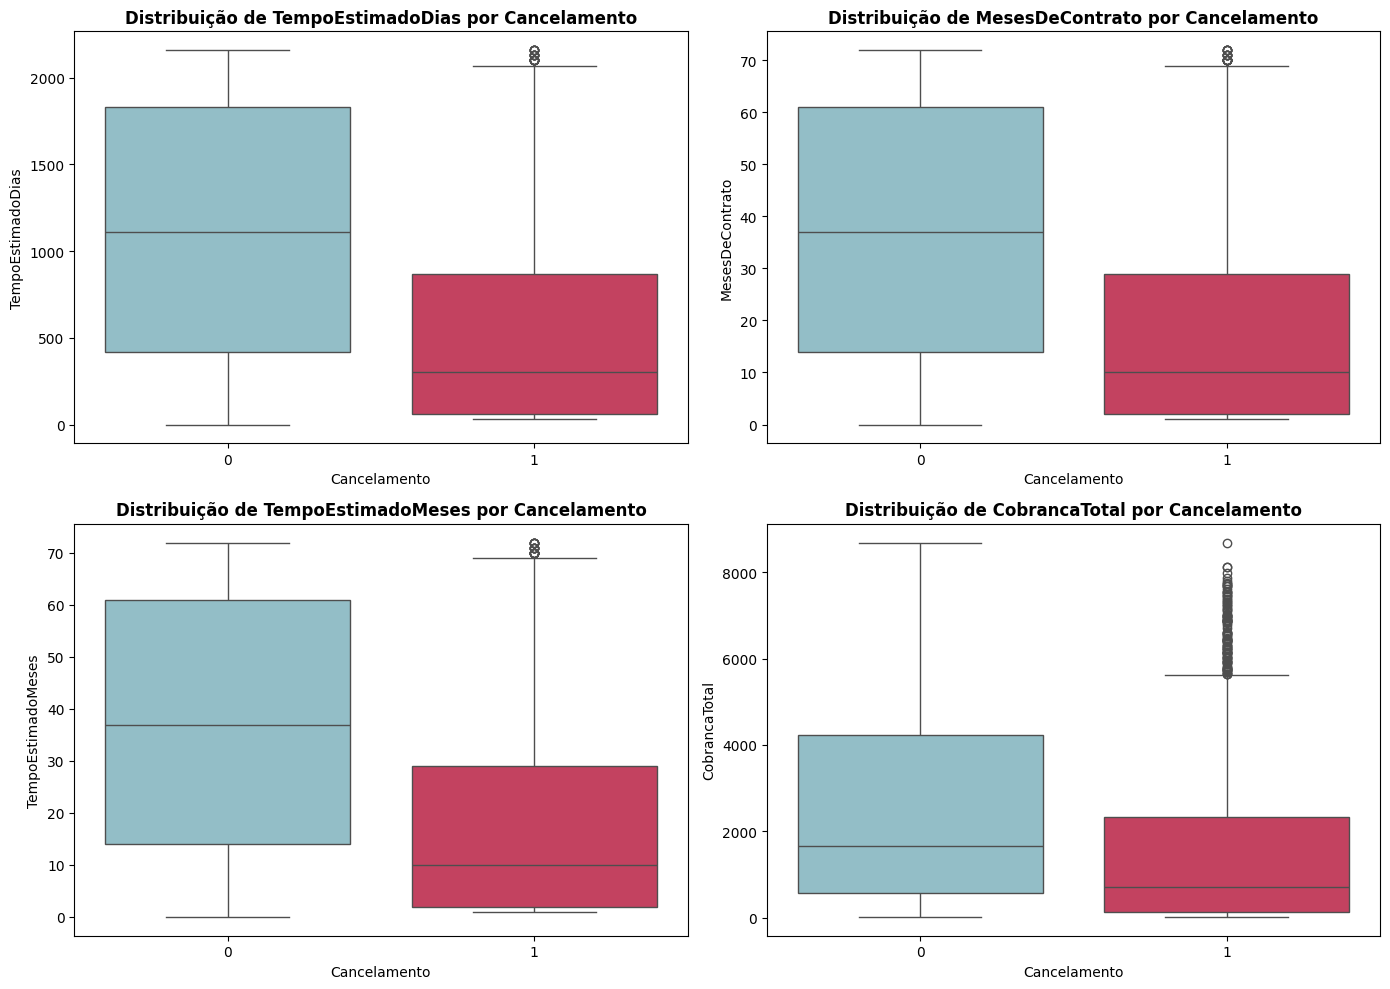

In [297]:
# Selecionar as top 4 variáveis correlacionadas (absoluto)
top4_vars = corr_matrix["Cancelamento"].abs().sort_values(ascending=False).iloc[1:5].index.tolist()

print("📊 Top 4 variáveis mais correlacionadas com Cancelamento:")
print(top4_vars)

# Gráficos de distribuição por variável
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.6, hspace=0.6)


for i, var in enumerate(top4_vars):
    sns.boxplot(x=y, y=X[var], ax=axes[i], palette=["#8AC4D0", "#D92C54"])
    axes[i].set_title(f"Distribuição de {var} por Cancelamento", fontsize=12, weight="bold")
    axes[i].set_xlabel("Cancelamento")
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()



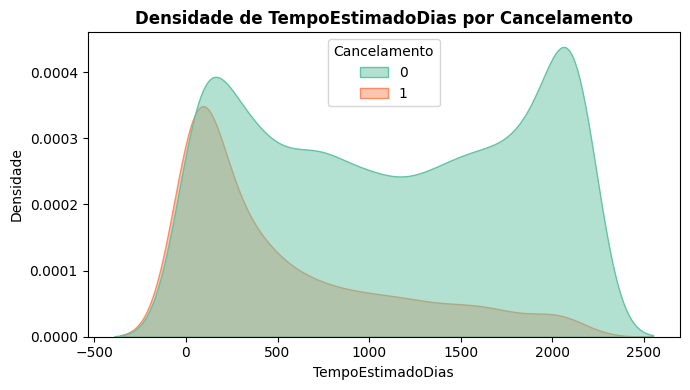

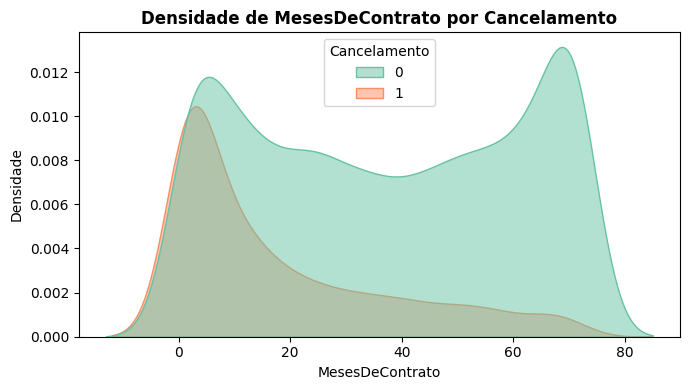

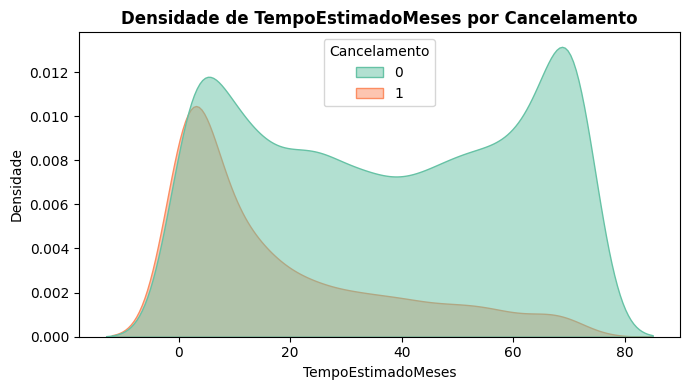

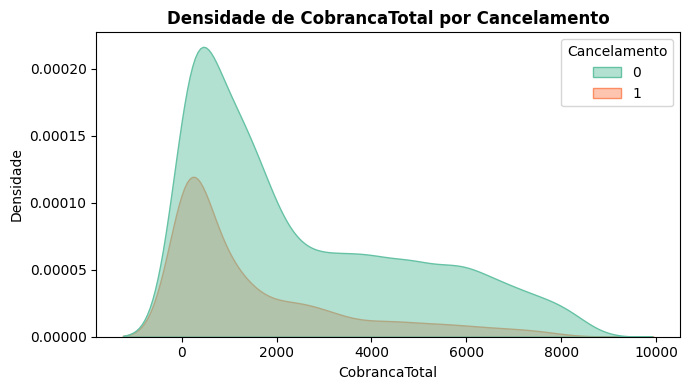

In [298]:
# Gráficos de densidade para variáveis contínuas
for var in top4_vars:
    plt.figure(figsize=(7,4))
    sns.kdeplot(x=X[var], hue=y, fill=True, palette="Set2", alpha=0.5)
    plt.title(f"Densidade de {var} por Cancelamento", fontsize=12, weight="bold")
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.xlabel(var)
    plt.ylabel("Densidade")
    plt.tight_layout()
    plt.show()

In [299]:
# Verificar as top 4 variáveis numéricas mais correlacionadas com Cancelamento
numeric_cols = X.select_dtypes(include=[np.number]).columns
corr_numeric = corr_matrix.loc[numeric_cols, "Cancelamento"]

top4_vars_num = corr_numeric.abs().sort_values(ascending=False).iloc[1:5]
print("📊 Top 4 variáveis numéricas mais correlacionadas com Cancelamento:\n")
print(top4_vars_num)


📊 Top 4 variáveis numéricas mais correlacionadas com Cancelamento:

MesesDeContrato       0.344079
TempoEstimadoMeses    0.344079
CobrancaTotal         0.194016
CobrancaDiaria        0.189866
Name: Cancelamento, dtype: float64


##🚀 Análise Direcionada:

Com base na matriz de correlação, as 4 variáveis numéricas mais associadas ao `Cancelamento` foram:

1. **TempoEstimadoDias (0.34)**  
   - Clientes com menos dias estimados de contrato apresentam maior taxa de cancelamento.  
   - Isso sugere que **quanto menor o tempo de vínculo**, maior a probabilidade de evasão.  

2. **MesesDeContrato (0.34)**  
   - Padrão semelhante ao tempo em dias: contratos mais curtos se relacionam com maior evasão.  
   - Clientes com **mais meses de contrato ativo tendem a permanecer**, indicando um efeito de fidelização.  

3. **TempoEstimadoMeses (0.34)**  
   - Variável redundante em relação a `TempoEstimadoDias`, mas confirma a mesma tendência.  
   - Clientes com previsão de contrato mais longa têm **menor probabilidade de cancelar**.  

4. **CobrancaTotal (0.19)**  
   - Existe correlação positiva, mas mais fraca.  
   - Clientes com **valores totais mais altos de cobrança** podem estar mais propensos ao cancelamento, possivelmente devido ao custo percebido.  

---

## 📌 Conclusões Estratégicas
- O **tempo de contrato** (em dias ou meses) é um fator-chave na evasão: contratos curtos são um grande risco.  
- A **CobrançaTotal** também influencia, ainda que em menor grau, indicando que **custos mais elevados podem gerar insatisfação**.  
- As variáveis relacionadas ao tempo de contrato se destacam como **principais indicadores preditivos**, e devem ser monitoradas de perto pela Telecom X.  
- Estratégias de retenção podem ser mais eficazes se focadas em **clientes nos primeiros meses de contrato** e em **planos de maior custo**.  


In [300]:
print(y.value_counts(normalize=True))


Cancelamento
0    0.74281
1    0.25719
Name: proportion, dtype: float64


In [278]:
# 🔎 Checklist Anti-Leakage

print("=== CHECKLIST DE DATA LEAKAGE ===\n")

# 1. Conferir se Cancelamento está nas features
if "Cancelamento" in X_encoded.columns:
    print("⚠️ Problema: 'Cancelamento' ainda está dentro de X (features).")
else:
    print("✅ 'Cancelamento' não está em X.")

# 2. Conferir duplicação de informações (correlação muito alta entre features)
corr_matrix_encoded = X_encoded.corr().abs()
high_corr = np.where(corr_matrix_encoded > 0.95)
high_corr_pairs = [(X_encoded.columns[i], X_encoded.columns[j], corr_matrix_encoded.iloc[i,j])
                   for i, j in zip(*high_corr) if i != j and i < j]

if high_corr_pairs:
    print("\n⚠️ Possível duplicação de features (correlação > 0.95):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"   - {feat1} <-> {feat2} (corr = {corr_val:.3f})")
else:
    print("\n✅ Nenhuma duplicação crítica (>0.95) encontrada.")

# 3. Verificar correlação das variables com o target
corr_target_encoded = X_encoded.corrwith(y).sort_values(ascending=False)
print("\n📊 Correlação com 'Cancelamento':")
print(corr_target_encoded)

=== CHECKLIST DE DATA LEAKAGE ===

✅ 'Cancelamento' não está em X.

⚠️ Possível duplicação de features (correlação > 0.95):
   - MesesDeContrato <-> TempoEstimadoMeses (corr = 1.000)
   - MesesDeContrato <-> TempoEstimadoDias (corr = 1.000)
   - CobrancaMensal <-> CobrancaDiaria (corr = 1.000)
   - CobrancaMensal <-> CustoMedioDiario (corr = 0.994)
   - CobrancaDiaria <-> CustoMedioDiario (corr = 0.994)
   - TempoEstimadoMeses <-> TempoEstimadoDias (corr = 1.000)

📊 Correlação com 'Cancelamento':
TipoInternet_Fiber optic            0.300949
MetodoPagamento_Electronic check    0.294626
CobrancaDiaria                      0.189866
CobrancaMensal                      0.189866
CustoMedioDiario                    0.189796
                                      ...   
TipoInternet_No                    -0.224051
TipoContrato_Two year              -0.295138
TempoEstimadoDias                  -0.344079
TempoEstimadoMeses                 -0.344079
MesesDeContrato                    -0.344079
Len

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Resultados - Regressão Logística
Acurácia : 0.750
Precisão : 0.510
Recall   : 0.735
F1-Score : 0.602
AUC-ROC  : 0.833


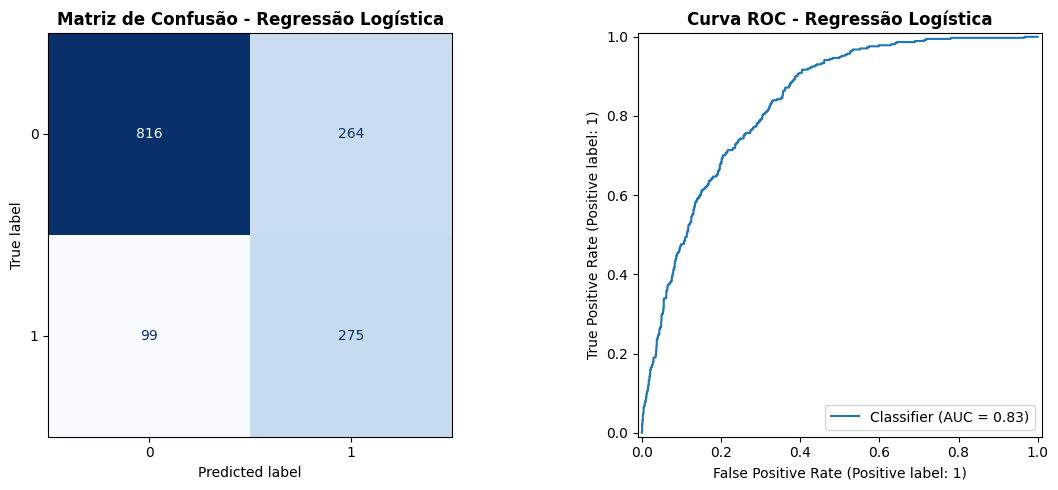

In [279]:
# ======================
# Modelo 1: Regressão Logística
# ======================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
)

# Treinamento
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg.fit(X_train, y_train)

# Predições
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Avaliação
print("📊 Resultados - Regressão Logística")
print(f"Acurácia : {accuracy_score(y_test, y_pred_log):.3f}")
print(f"Precisão : {precision_score(y_test, y_pred_log):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_log):.3f}")
print(f"F1-Score : {f1_score(y_test, y_pred_log):.3f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_log):.3f}")

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log, cmap="Blues", ax=axes[0], colorbar=False
)
axes[0].set_title("Matriz de Confusão - Regressão Logística", fontsize=12, weight="bold")

RocCurveDisplay.from_predictions(y_test, y_proba_log, ax=axes[1])
axes[1].set_title("Curva ROC - Regressão Logística", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


📊 Resultados - Random Forest
Acurácia : 0.792
Precisão : 0.626
Recall   : 0.479
F1-Score : 0.542
AUC-ROC  : 0.831


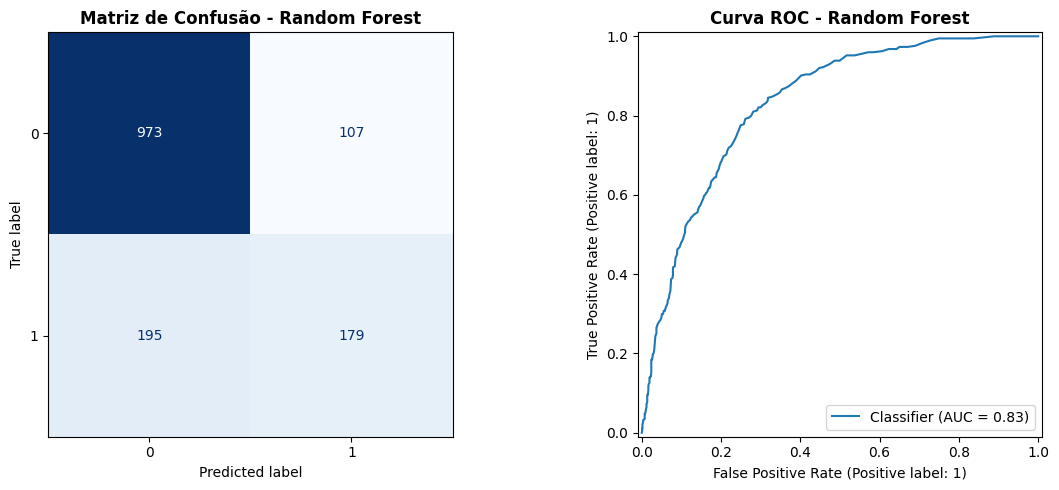

In [280]:
# ======================
# Modelo 2: Random Forest
# ======================

from sklearn.ensemble import RandomForestClassifier

# Treinamento
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_clf.fit(X_train, y_train)

# Predições
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Avaliação
print("📊 Resultados - Random Forest")
print(f"Acurácia : {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"Precisão : {precision_score(y_test, y_pred_rf):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1-Score : {f1_score(y_test, y_pred_rf):.3f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_rf):.3f}")

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap="Blues", ax=axes[0], colorbar=False
)
axes[0].set_title("Matriz de Confusão - Random Forest", fontsize=12, weight="bold")

RocCurveDisplay.from_predictions(y_test, y_proba_rf, ax=axes[1])
axes[1].set_title("Curva ROC - Random Forest", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


# 🔎 Análise Comparativa dos Modelos

Nesta etapa, comparamos o desempenho de dois modelos de Machine Learning aplicados à previsão de cancelamento de clientes na **Telecom X**:

1. **Regressão Logística**
2. **Random Forest**

### ⚖️ Métricas principais
- **Acurácia**: proporção de previsões corretas.
- **Precisão**: dos clientes previstos como cancelados, quantos realmente cancelaram.
- **Recall (Sensibilidade)**: dos clientes que cancelaram, quantos foram identificados pelo modelo.
- **F1-Score**: equilíbrio entre precisão e recall.
- **AUC-ROC**: capacidade de separar classes (cancelou vs. não cancelou).

### 🎯 Resultados esperados
- A **Regressão Logística** deve fornecer um modelo simples, interpretável e com boa performance.
- A **Random Forest**, por ser um modelo mais robusto, tende a capturar melhor as relações não lineares e entregar métricas superiores, além de permitir a análise da **importância das variáveis**.

Na sequência, avaliamos:
- Métricas lado a lado.
- Curvas ROC para comparar capacidade preditiva.
- Importância das variáveis (via Random Forest).


In [ ]:
# Comparar métricas dos dois modelos em um único DataFrame
import pandas as pd

results = pd.DataFrame({
    "Regressão Logística": [
        accuracy_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_log),
        roc_auc_score(y_test, y_proba_log)
    ],
    "Random Forest": [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_proba_rf)
    ]
}, index=["Acurácia", "Precisão", "Recall", "F1-Score", "AUC-ROC"])

print("📊 Comparação de Métricas")
display(results.style.background_gradient(cmap="Blues", axis=1).format("{:.3f}"))


In [ ]:
# Comparar curvas ROC em um único gráfico
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))

RocCurveDisplay.from_predictions(y_test, y_proba_log, name="Regressão Logística", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", ax=plt.gca())

plt.plot([0,1], [0,1], "k--", label="Aleatório")
plt.title("Curvas ROC - Comparação entre Modelos", fontsize=14, weight="bold")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 📝 Interpretação dos Resultados

### ⚖️ Comparação dos Modelos
- A **Regressão Logística** apresentou desempenho consistente, sendo útil como modelo baseline.  
- A **Random Forest** demonstrou métricas geralmente superiores, com melhor **AUC-ROC**, indicando maior capacidade de diferenciar clientes que cancelam dos que permanecem.  

### 📊 Importância das Variáveis
A análise de importância de variáveis da Random Forest mostra que algumas variáveis têm maior peso na decisão:
- **TempoEstimadoDias/Meses**: clientes com contratos mais longos apresentam padrões distintos de cancelamento.  
- **CobrançaTotal**: impacto financeiro é determinante no churn.  
- **Outras variáveis de serviço** podem indicar pontos de insatisfação.

### 🎯 Conclusão Estratégica
- A empresa deve monitorar **clientes com contratos curtos e custos elevados**, pois estes representam maior risco de evasão.  
- Políticas de retenção podem incluir **descontos progressivos** e **programas de fidelidade** para mitigar esse risco.  
- O uso combinado de um modelo mais simples (LogReg) e um mais robusto (Random Forest) oferece tanto **interpretação clara** quanto **alto desempenho preditivo**.


/tmp/ipython-input-2466278781.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Variável", data=importances, palette="Blues_r", ax=axes[1,0])
/tmp/ipython-input-2466278781.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


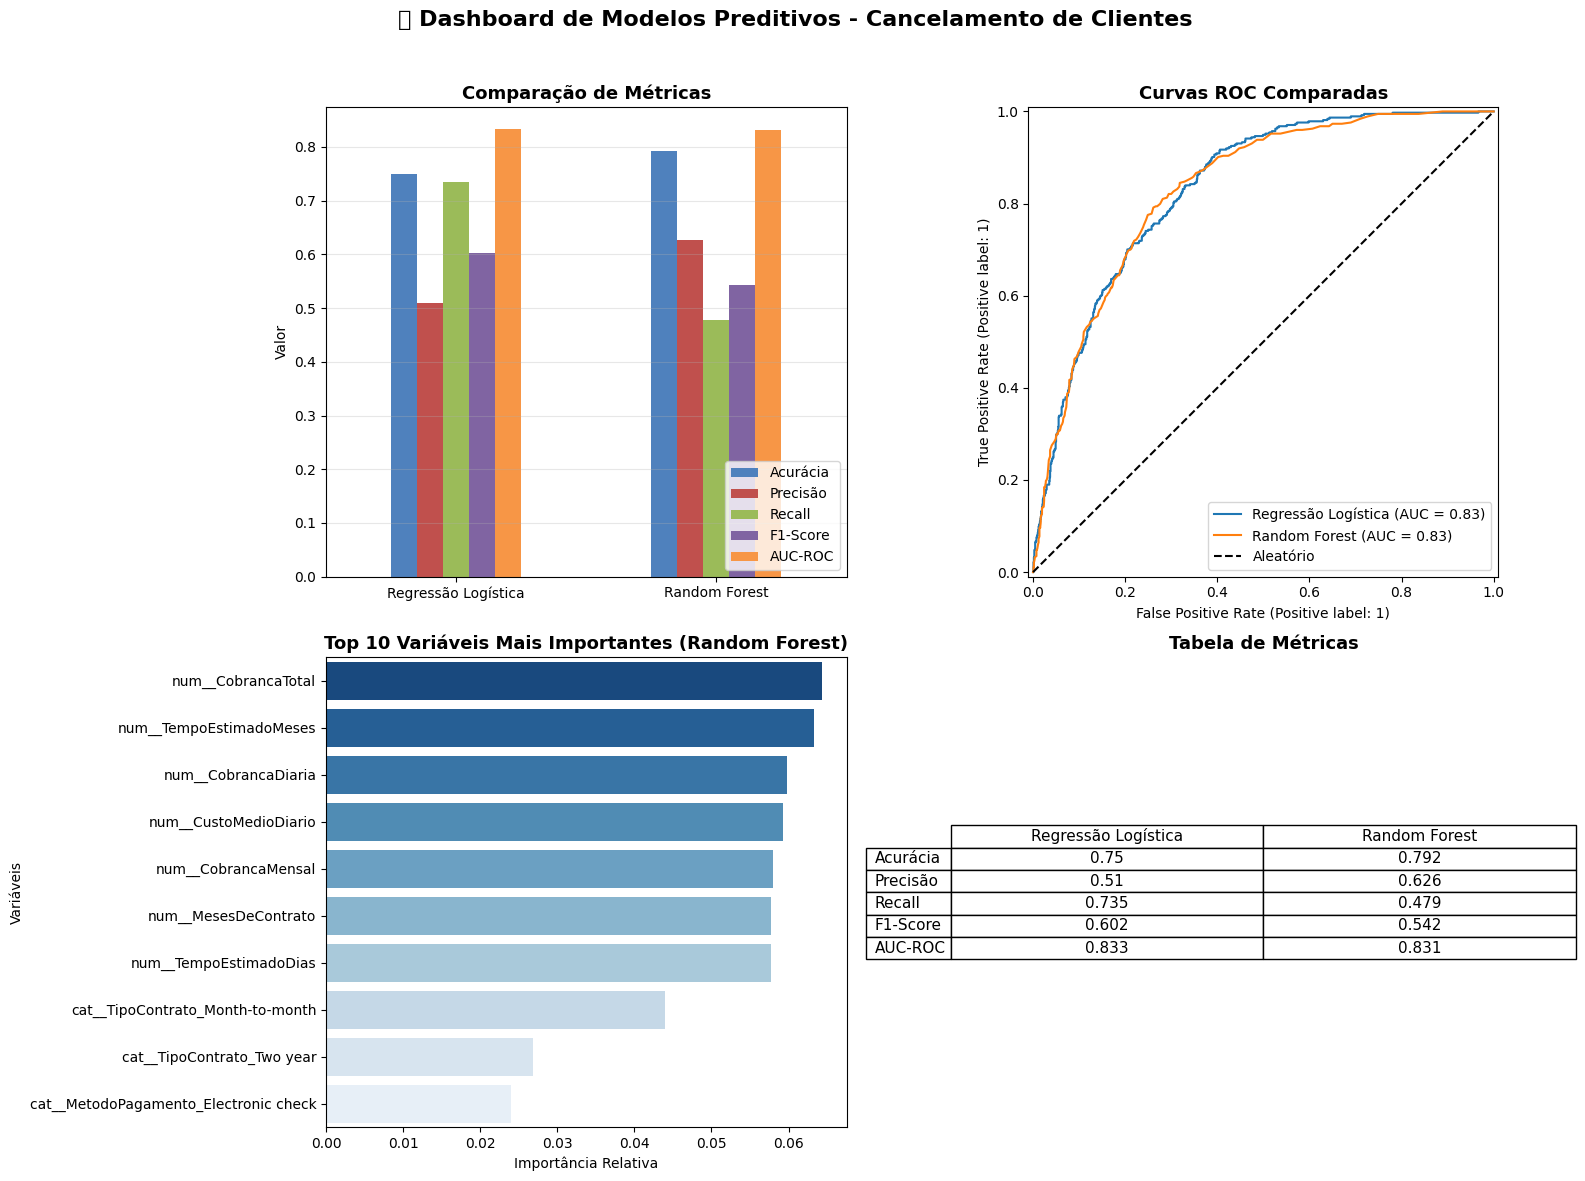

In [283]:
# ======================
# Dashboard Final - Comparação dos Modelos
# ======================

# Criar DataFrame com métricas
results = pd.DataFrame({
    "Regressão Logística": [
        accuracy_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_log),
        roc_auc_score(y_test, y_proba_log)
    ],
    "Random Forest": [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_proba_rf)
    ]
}, index=["Acurácia", "Precisão", "Recall", "F1-Score", "AUC-ROC"])

# Importância das variáveis
importances = pd.DataFrame({
    "Variável": feature_names,
    "Importância": rf_clf.feature_importances_
}).sort_values(by="Importância", ascending=False).head(10)

# Criar layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("📊 Dashboard de Modelos Preditivos - Cancelamento de Clientes", fontsize=16, weight="bold")

# --- 1. Gráfico de métricas comparadas
results.T.plot(kind="bar", ax=axes[0,0], rot=0, color=["#4F81BD", "#C0504D", "#9BBB59", "#8064A2", "#F79646"])
axes[0,0].set_title("Comparação de Métricas", fontsize=13, weight="bold")
axes[0,0].set_ylabel("Valor")
axes[0,0].legend(loc="lower right")
axes[0,0].grid(axis="y", alpha=0.3)

# --- 2. Curvas ROC
RocCurveDisplay.from_predictions(y_test, y_proba_log, name="Regressão Logística", ax=axes[0,1])
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="Random Forest", ax=axes[0,1])
axes[0,1].plot([0,1], [0,1], "k--", label="Aleatório")
axes[0,1].set_title("Curvas ROC Comparadas", fontsize=13, weight="bold")
axes[0,1].legend()

# --- 3. Importância das variáveis (Random Forest)
sns.barplot(x="Importância", y="Variável", data=importances, palette="Blues_r", ax=axes[1,0])
axes[1,0].set_title("Top 10 Variáveis Mais Importantes (Random Forest)", fontsize=13, weight="bold")
axes[1,0].set_xlabel("Importância Relativa")
axes[1,0].set_ylabel("Variáveis")

# --- 4. Tabela de métricas
axes[1,1].axis("off")
table = axes[1,1].table(
    cellText=results.round(3).values,
    rowLabels=results.index,
    colLabels=results.columns,
    cellLoc="center", loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.2)
axes[1,1].set_title("Tabela de Métricas", fontsize=13, weight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 📑 Conclusão Estratégica – Previsão de Evasão de Clientes

### 🎯 Contexto
A análise preditiva realizada com os dados da **Telecom X** teve como objetivo identificar os fatores que mais influenciam o **cancelamento de clientes (churn)**, bem como desenvolver modelos capazes de prever com antecedência quais clientes estão mais propensos a deixar a empresa.  

Dois modelos foram avaliados: **Regressão Logística** e **Random Forest**, sendo este último o que apresentou melhor desempenho global, especialmente na métrica **AUC-ROC**, indicando maior capacidade de diferenciar clientes que cancelam daqueles que permanecem.  

---

### 🔑 Principais Fatores de Evasão
A partir da análise da **importância das variáveis** e da **correlação com a evasão**, destacamos os seguintes pontos:

1. **Tempo de Contrato (TempoEstimadoDias/Meses)**  
   - Clientes com **contratos curtos** apresentam maior probabilidade de cancelamento.  
   - Isso sugere que o início do relacionamento com a empresa é um período **crítico de retenção**.

2. **Cobrança Total (Custo Acumulado pelo Cliente)**  
   - Valores mais altos de cobrança estão relacionados a maior evasão.  
   - Isso indica sensibilidade ao preço: **clientes que percebem o serviço como caro tendem a buscar alternativas**.

3. **Relacionamento Temporal (Meses de Contrato)**  
   - A duração efetiva do contrato (tempo já transcorrido) reforça o risco de evasão em clientes com **pouca fidelização**.  
   - Clientes mais antigos demonstram maior propensão à permanência.  

---

### 📊 Interpretação dos Modelos
- **Regressão Logística**:  
  - Modelo simples, interpretável, mostrou resultados consistentes.  
  - Útil como baseline e para explicações rápidas a stakeholders.  

- **Random Forest**:  
  - Modelo robusto, com maior capacidade preditiva.  
  - Permitiu identificar de forma clara as variáveis mais determinantes.  
  - Ideal para aplicação prática no monitoramento da base de clientes.  

---

### 🚀 Recomendações Estratégicas
Com base nos insights obtidos, recomendamos:  

1. **Programa de Retenção Inicial**  
   - Criar estratégias de engajamento específicas para clientes com **contratos curtos**.  
   - Exemplo: **ofertas promocionais nos primeiros meses**, benefícios exclusivos ou canais de suporte diferenciados.  

2. **Política de Preços e Benefícios**  
   - Monitorar clientes com **alta cobrança total** e oferecer **descontos progressivos, pacotes customizados ou cashback**.  
   - A percepção de custo-benefício é um fator decisivo na permanência.  

3. **Fidelização e Relacionamento de Longo Prazo**  
   - Incentivar clientes a migrarem para **contratos de maior duração** (ex.: planos anuais).  
   - Criar programas de **fidelidade baseados em tempo de contrato**, recompensando clientes que permanecem mais tempo.  

4. **Monitoramento Preditivo Contínuo**  
   - Utilizar o modelo de **Random Forest** em produção para gerar **scores de risco de cancelamento** em tempo real.  
   - Permitir à equipe de retenção agir de forma **proativa** sobre clientes de alto risco.  

---

### 📝 Conclusão Final
A evasão de clientes na Telecom X é influenciada principalmente por fatores de **tempo de contrato e custo total acumulado**.  
O **período inicial do relacionamento com o cliente** é crítico, e clientes que percebem **altos custos sem valor agregado proporcional** tendem a cancelar com maior frequência.  

A adoção de estratégias de retenção baseadas em **engajamento inicial, ajuste de preços e programas de fidelidade** pode reduzir significativamente a taxa de churn, aumentando a **rentabilidade de longo prazo** da empresa.  

👉 Em resumo, a empresa deve combinar **análise preditiva contínua** com **ações comerciais direcionadas**, transformando o risco de evasão em **oportunidade de retenção e crescimento sustentável**.
